### Vectorización de texto y modelo de clasificación Naïve Bayes con el dataset 20 newsgroups

In [1]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.metrics import f1_score

# 20newsgroups por ser un dataset clásico de NLP ya viene incluido y formateado
# en sklearn
from sklearn.datasets import fetch_20newsgroups
import numpy as np

## Carga de datos

In [2]:
# cargamos los datos (ya separados de forma predeterminada en train y test)
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

## Vectorización

In [3]:
# instanciamos un vectorizador
# ver diferentes parámetros de instanciación en la documentación de sklearn
tfidfvect = TfidfVectorizer()

In [4]:
# en el atributo `data` accedemos al texto
newsgroups_train.data[0]

'I was wondering if anyone out there could enlighten me on this car I saw\nthe other day. It was a 2-door sports car, looked to be from the late 60s/\nearly 70s. It was called a Bricklin. The doors were really small. In addition,\nthe front bumper was separate from the rest of the body. This is \nall I know. If anyone can tellme a model name, engine specs, years\nof production, where this car is made, history, or whatever info you\nhave on this funky looking car, please e-mail.'

In [5]:
# con la interfaz habitual de sklearn podemos fitear el vectorizador
# (obtener el vocabulario y calcular el vector IDF)
# y transformar directamente los datos
X_train = tfidfvect.fit_transform(newsgroups_train.data)
# `X_train` la podemos denominar como la matriz documento-término

In [6]:
# recordar que las vectorizaciones por conteos son esparsas
# por ello sklearn convenientemente devuelve los vectores de documentos
# como matrices esparsas
print(type(X_train))
print(f'shape: {X_train.shape}')
print(f'cantidad de documentos: {X_train.shape[0]}')
print(f'tamaño del vocabulario (dimensionalidad de los vectores): {X_train.shape[1]}')

<class 'scipy.sparse._csr.csr_matrix'>
shape: (11314, 101631)
cantidad de documentos: 11314
tamaño del vocabulario (dimensionalidad de los vectores): 101631


In [7]:
# una vez fiteado el vectorizador, podemos acceder a atributos como el vocabulario
# aprendido. Es un diccionario que va de términos a índices.
# El índice es la posición en el vector de documento.
tfidfvect.vocabulary_['car']

25775

In [8]:
# es muy útil tener el diccionario opuesto que va de índices a términos
idx2word = {v: k for k,v in tfidfvect.vocabulary_.items()}

In [9]:
# en `y_train` guardamos los targets que son enteros
y_train = newsgroups_train.target
y_train[:10]

array([ 7,  4,  4,  1, 14, 16, 13,  3,  2,  4])

In [10]:
# hay 20 clases correspondientes a los 20 grupos de noticias
print(f'clases {np.unique(newsgroups_test.target)}')
newsgroups_test.target_names

clases [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

## Similaridad de documentos

In [11]:
# Veamos similaridad de documentos. Tomemos algún documento
idx = 4811
print(newsgroups_train.data[idx])

THE WHITE HOUSE

                  Office of the Press Secretary
                   (Pittsburgh, Pennslyvania)
______________________________________________________________
For Immediate Release                         April 17, 1993     

             
                  RADIO ADDRESS TO THE NATION 
                        BY THE PRESIDENT
             
                Pittsburgh International Airport
                    Pittsburgh, Pennsylvania
             
             
10:06 A.M. EDT
             
             
             THE PRESIDENT:  Good morning.  My voice is coming to
you this morning through the facilities of the oldest radio
station in America, KDKA in Pittsburgh.  I'm visiting the city to
meet personally with citizens here to discuss my plans for jobs,
health care and the economy.  But I wanted first to do my weekly
broadcast with the American people. 
             
             I'm told this station first broadcast in 1920 when
it reported that year's presidential elec

In [12]:
# midamos la similaridad coseno con todos los documentos de train
cossim = cosine_similarity(X_train[idx], X_train)[0]

In [13]:
# podemos ver los valores de similaridad ordenados de mayor a menos
np.sort(cossim)[::-1]

array([1.        , 0.70930477, 0.67474953, ..., 0.        , 0.        ,
       0.        ])

In [14]:
# y a qué documentos corresponden
np.argsort(cossim)[::-1]

array([ 4811,  6635,  4253, ...,  1534, 10055,  4750], dtype=int64)

In [15]:
# los 5 documentos más similares:
mostsim = np.argsort(cossim)[::-1][1:6]

In [16]:
# el documento original pertenece a la clase:
newsgroups_train.target_names[y_train[idx]]

'talk.politics.misc'

In [17]:
# y los 5 más similares son de las clases:
for i in mostsim:
  print(newsgroups_train.target_names[y_train[i]])

talk.politics.misc
talk.politics.misc
talk.politics.misc
talk.politics.misc
talk.politics.misc


### Modelo de clasificación Naïve Bayes

In [18]:
# es muy fácil instanciar un modelo de clasificación Naïve Bayes y entrenarlo con sklearn
clf = MultinomialNB()
clf.fit(X_train, y_train)

MultinomialNB()

In [19]:
# con nuestro vectorizador ya fiteado en train, vectorizamos los textos
# del conjunto de test
X_test = tfidfvect.transform(newsgroups_test.data)
y_test = newsgroups_test.target
y_pred =  clf.predict(X_test)

In [20]:
# el F1-score es una metrica adecuada para reportar desempeño de modelos de claificación
# es robusta al desbalance de clases. El promediado 'macro' es el promedio de los
# F1-score de cada clase. El promedio 'micro' es equivalente a la accuracy que no
# es una buena métrica cuando los datasets son desbalanceados
f1_score(y_test, y_pred, average='macro')

0.5854345727938506

### Consigna del desafío 1

**1**. Vectorizar documentos. Tomar 5 documentos al azar y medir similaridad con el resto de los documentos.
Estudiar los 5 documentos más similares de cada uno analizar si tiene sentido
la similaridad según el contenido del texto y la etiqueta de clasificación.

**2**. Entrenar modelos de clasificación Naïve Bayes para maximizar el desempeño de clasificación
(f1-score macro) en el conjunto de datos de test. Considerar cambiar parámteros
de instanciación del vectorizador y los modelos y probar modelos de Naïve Bayes Multinomial
y ComplementNB.

**3**. Transponer la matriz documento-término. De esa manera se obtiene una matriz
término-documento que puede ser interpretada como una colección de vectorización de palabras.
Estudiar ahora similaridad entre palabras tomando 5 palabras y estudiando sus 5 más similares. **La elección de palabras no debe ser al azar para evitar la aparición de términos poco interpretables, elegirlas "manualmente"**.



In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.datasets import fetch_20newsgroups
import numpy as np
import random

# Cargar los datos
newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))

# Crear una instancia de TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Ajustar y transformar los datos
X_tfidf = tfidf_vectorizer.fit_transform(newsgroups.data)

# Seleccionar 5 documentos al azar
random_indices = random.sample(range(len(newsgroups.data)), 5)
random_docs = X_tfidf[random_indices]

# Calcular la similitud del coseno entre los 5 documentos seleccionados y el resto
similarity_matrix = cosine_similarity(random_docs, X_tfidf)

# Encontrar los 5 documentos más similares para cada uno de los documentos seleccionados
most_similar_docs = []

for i, similarities in enumerate(similarity_matrix):
    # Ordenar las similitudes y seleccionar los índices de los 5 documentos más similares (excluyendo el propio documento)
    similar_indices = np.argsort(-similarities)[1:6]
    most_similar_docs.append(similar_indices)

# Mostrar las clases disponibles en el conjunto de datos
print(f'Clases disponibles: {np.unique(newsgroups.target)}')
print('Nombres de las clases:', newsgroups.target_names)

# Mostrar los índices de los documentos seleccionados al azar y sus documentos más similares junto con las etiquetas
for i, similar_docs in enumerate(most_similar_docs):
    print(f"Documento seleccionado {i+1} (índice {random_indices[i]}, etiqueta {newsgroups.target[random_indices[i]]} - {newsgroups.target_names[newsgroups.target[random_indices[i]]]}):")
    print("Documentos más similares (índices y etiquetas):")
    for idx in similar_docs:
        print(f"Índice {idx}, etiqueta {newsgroups.target[idx]} - {newsgroups.target_names[newsgroups.target[idx]]}")
    print()

#  Mostrar los textos de los documentos seleccionados y sus más similares
for i, similar_docs in enumerate(most_similar_docs):
    print(f"Texto del documento seleccionado {i+1} (índice {random_indices[i]}, etiqueta {newsgroups.target[random_indices[i]]} - {newsgroups.target_names[newsgroups.target[random_indices[i]]]}):")
    print(newsgroups.data[random_indices[i]])
    print("\nDocumentos más similares (textos y etiquetas):")
    for idx in similar_docs:
        print(f"Índice {idx}, etiqueta {newsgroups.target[idx]} - {newsgroups.target_names[newsgroups.target[idx]]}:\n", newsgroups.data[idx])
        print("\n" + "="*80 + "\n")


Clases disponibles: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Nombres de las clases: ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']
Documento seleccionado 1 (índice 322, etiqueta 15 - soc.religion.christian):
Documentos más similares (índices y etiquetas):
Índice 10544, etiqueta 15 - soc.religion.christian
Índice 8723, etiqueta 15 - soc.religion.christian
Índice 16702, etiqueta 19 - talk.religion.misc
Índice 10586, etiqueta 13 - sci.med
Índice 5029, etiqueta 18 - talk.politics.misc

Documento seleccionado 2 (índice 368, etiqueta 16 - talk.politics.guns):
Documentos más similares (índices y etiquetas):
Índice 7485, etiqueta 16

Buscando los mejores parámetros para MultinomialNB...
Mejores parámetros para MultinomialNB: {'alpha': 0.1}
Mejor F1 score para MultinomialNB: 0.7188497427747561
Buscando los mejores parámetros para ComplementNB...
Mejores parámetros para ComplementNB: {'alpha': 0.1, 'norm': False}
Mejor F1 score para ComplementNB: 0.7656097292010164
F1 score en el conjunto de prueba para MultinomialNB: 0.6564514103512165
F1 score en el conjunto de prueba para ComplementNB: 0.6953652590540836


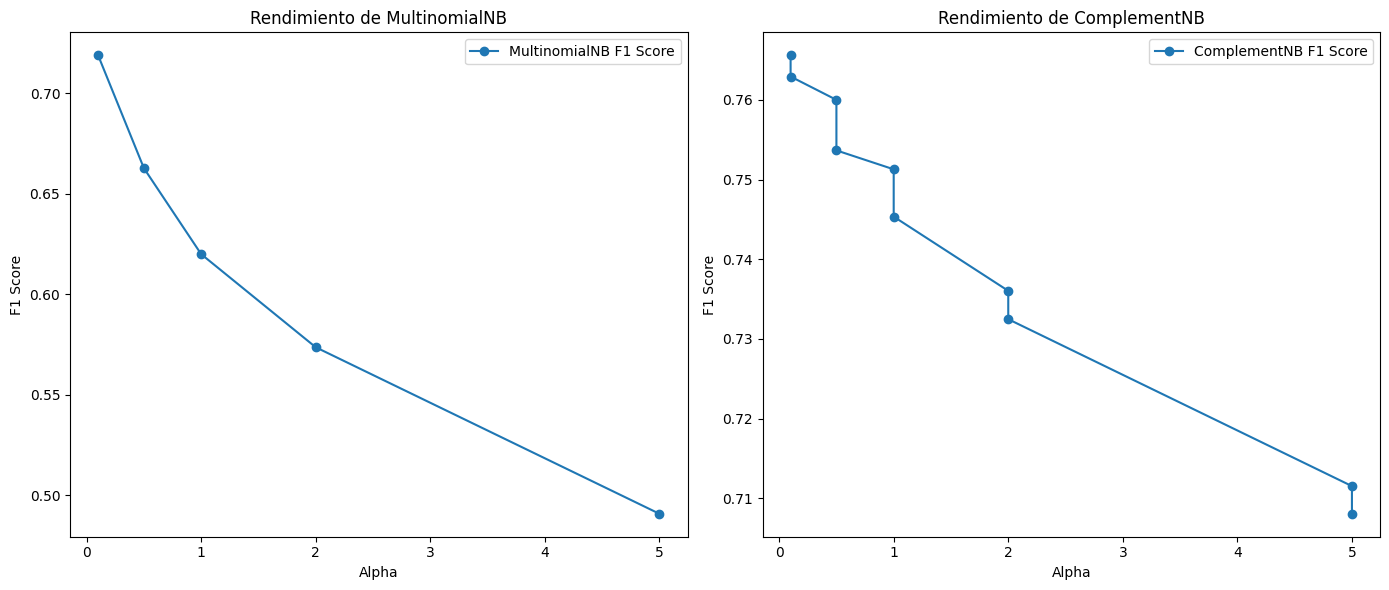

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.metrics import f1_score, make_scorer
from sklearn.datasets import fetch_20newsgroups

# Cargar los datos
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))

# Crear una instancia de TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Ajustar y transformar los datos de entrenamiento y prueba
X_train_tfidf = tfidf_vectorizer.fit_transform(newsgroups_train.data)
X_test_tfidf = tfidf_vectorizer.transform(newsgroups_test.data)
y_train = newsgroups_train.target
y_test = newsgroups_test.target

# Definir los modelos
models = {
    'MultinomialNB': MultinomialNB(),
    'ComplementNB': ComplementNB()
}

# Definir los parámetros de búsqueda
param_grid = {
    'MultinomialNB': {
        'alpha': [0.1, 0.5, 1.0, 2.0, 5.0]
    },
    'ComplementNB': {
        'alpha': [0.1, 0.5, 1.0, 2.0, 5.0],
        'norm': [False, True]
    }
}

# Definir el F1 score como métrica
scorer = make_scorer(f1_score, average='macro')

# Diccionario para almacenar los mejores modelos y resultados
best_models = {}
results = {}

# Realizar la búsqueda de hiperparámetros para cada modelo
for model_name in models:
    print(f"Buscando los mejores parámetros para {model_name}...")
    grid_search = GridSearchCV(models[model_name], param_grid[model_name], scoring=scorer, cv=5, n_jobs=-1)
    grid_search.fit(X_train_tfidf, y_train)
    best_models[model_name] = grid_search.best_estimator_
    results[model_name] = grid_search.cv_results_
    print(f"Mejores parámetros para {model_name}: {grid_search.best_params_}")
    print(f"Mejor F1 score para {model_name}: {grid_search.best_score_}")

# Evaluar los mejores modelos en el conjunto de prueba
for model_name in best_models:
    y_pred = best_models[model_name].predict(X_test_tfidf)
    test_f1 = f1_score(y_test, y_pred, average='macro')
    print(f"F1 score en el conjunto de prueba para {model_name}: {test_f1}")

# Graficar los resultados
plt.figure(figsize=(14, 6))

for model_name in results:
    plt.subplot(1, 2, list(results.keys()).index(model_name) + 1)
    mean_scores = results[model_name]['mean_test_score']
    params = results[model_name]['param_alpha']
    plt.plot(params, mean_scores, marker='o', label=f'{model_name} F1 Score')
    plt.xlabel('Alpha')
    plt.ylabel('F1 Score')
    plt.title(f'Rendimiento de {model_name}')
    plt.legend()

plt.tight_layout()
plt.show()


Término seleccionado 1 (índice 62290, término 'hockey'):
Términos más similares (índices y términos):
Índice 50367, término 'espn'
Índice 86286, término 'ncaa'
Índice 120906, término 'umaine'
Índice 56382, término 'game'
Índice 111570, término 'sport'

Término seleccionado 2 (índice 60542, término 'hardware'):
Términos más similares (índices y términos):
Índice 110615, término 'software'
Índice 60386, término 'handshaking'
Índice 121172, término 'unconditionally'
Índice 99689, término 'quickkeys'
Índice 126172, término 'wacks'

Término seleccionado 3 (índice 96691, término 'president'):
Términos más similares (índices y términos):
Índice 82264, término 'miyazawa'
Índice 20137, término '_________________________________________________________________'
Índice 107512, término 'secretary'
Índice 84469, término 'mubarek'
Índice 24846, término 'amato'

Término seleccionado 4 (índice 95113, término 'player'):
Términos más similares (índices y términos):
Índice 58553, término 'grapes'
Índice 

C:\Users\c679529\AppData\Local\Temp\ipykernel_26376\3883656861.py:58: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


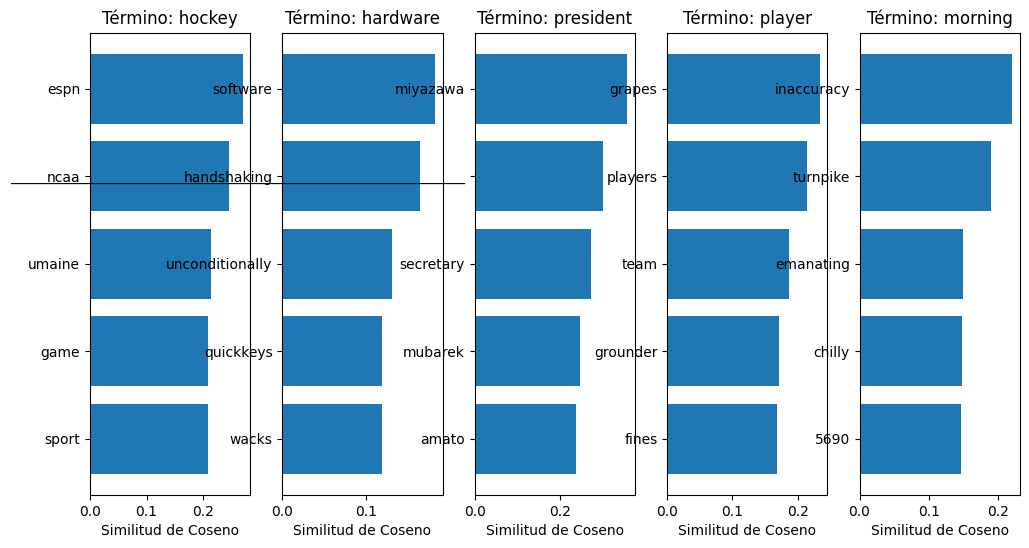

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.datasets import fetch_20newsgroups

# Cargar los datos
newsgroups = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))

# Crear una instancia de TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer()

# Ajustar y transformar los datos
X_tfidf = tfidf_vectorizer.fit_transform(newsgroups.data)

# Transponer la matriz documento-término para obtener una matriz término-documento
X_tfidf_transposed = X_tfidf.T

# Obtener los nombres de los términos (palabras)
terms = tfidf_vectorizer.get_feature_names_out()

# Seleccionar palabras específicas
specific_terms = ['hockey', 'hardware', 'president','player','morning']
specific_indices = [np.where(terms == term)[0][0] for term in specific_terms]
specific_terms_matrix = X_tfidf_transposed[specific_indices]

# Calcular la similitud del coseno entre los términos seleccionados y el resto
similarity_matrix = cosine_similarity(specific_terms_matrix, X_tfidf_transposed)

# Encontrar los 5 términos más similares para cada uno de los términos seleccionados
most_similar_terms = []

for i, similarities in enumerate(similarity_matrix):
    # Ordenar las similitudes y seleccionar los índices de los 5 términos más similares (excluyendo el propio término)
    similar_indices = np.argsort(-similarities)[1:6]
    most_similar_terms.append(similar_indices)

# Mostrar los términos seleccionados al azar y sus términos más similares
for i, similar_terms in enumerate(most_similar_terms):
    print(f"Término seleccionado {i+1} (índice {specific_indices[i]}, término '{specific_terms[i]}'):")
    print("Términos más similares (índices y términos):")
    for idx in similar_terms:
        print(f"Índice {idx}, término '{terms[idx]}'")
    print()

#  Graficar la similitud entre los términos seleccionados y sus términos más similares
plt.figure(figsize=(12, 6))

for i, similarities in enumerate(similarity_matrix):
    plt.subplot(1, 5, i + 1)
    similar_indices = most_similar_terms[i]
    similar_terms = [terms[idx] for idx in similar_indices]
    plt.barh(similar_terms, similarities[similar_indices])
    plt.xlabel('Similitud de Coseno')
    plt.title(f'Término: {specific_terms[i]}')
    plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()
